In [105]:
import glob
import numpy as np
import hyss_util as hu
from datetime import datetime
from sklearn.decomposition import PCA, FactorAnalysis, FastICA
from plotting import set_defaults
import pandas as pd
from pandas.plotting import scatter_matrix
import scipy as sp
from scipy import stats
from scipy import signal
from scipy.optimize import minimize
from scipy.ndimage import gaussian_filter1d
import random
from sklearn.model_selection import train_test_split
import emcee
import corner
from IPython.display import display, Math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# -- set the types

kind = "veg"
comp = "bld"
runpca = False
runfan = False
runica = False
getndvi = False

In [3]:
# -- get wavelengths
waves = hu.read_header("../../../image_files/veg_00000.hdr")["waves"]

# -- define good scans
good = np.array([int(i) for i in np.load("../../../gdobler_output/output/good_scans.npy")])

reading and parsing ../../../image_files/veg_00000.hdr...


In [4]:
# -- load the comparison set (new)
#print("getting {0} spectra...".format(comp))
#blds = np.array([np.load(i) for i in
#                 sorted(glob.glob("../../../gdobler_output/output/{0}_specs/{0}_specs_avg*.npy"\
#                                      .format(comp)))])
#blds = blds[good]

In [5]:
# -- load comparison set from bld (left box)
print("getting {0} spectra...".format(comp))
try:
    blds = np.load("../../../gdobler_output/output/blds_left.npy")
except:
    blds = np.array([np.load(i)[:,:,:78].mean(-1).mean(-1) for i in
                    sorted(glob.glob("../../../gdobler_output/output/{0}_specs/{0}_specs*.npy"\
                                    .format(comp))) if "_avg" not in i])
    blds = blds[good]
    # np.save("../../../gdobler_output/output/blds_left.npy",blds)
    

getting bld spectra...


In [6]:
# -- normalize spectra
ms, bs = [], []
for ii in range(blds.shape[0]):
    # m, b = np.polyfit(blds[ii,:100],blds[0,:100],1)
    # m, b = np.polyfit(blds[ii],blds[0],1)
    m = blds[0].mean()/blds[ii].mean()
    b = 0.0
    ms.append(m)
    bs.append(b)

ms   = np.array(ms)
bs   = np.array(bs)
norm = blds*ms[:,np.newaxis] + bs[:,np.newaxis]
rat  = norm/norm[0]

In [7]:
# -- get vegetation spectra
print("getting {0} spectra...".format(kind))
if kind=="veg":
    vegs = np.load("../../../gdobler_output/output/veg_patch_specs.npy")
else:
    vegs = np.array([np.load(i) for i in
                     sorted(glob.glob("../../../gdobler_output/output/" + 
                                      "{0}_specs/{0}_specs_avg*.npy" \
                                      .format(kind)))])
    vegs = vegs[good]

getting veg spectra...


In [8]:
# -- normalize spectra
ss, os = [], []
for ii in range(vegs.shape[0]):
    # s, o = np.polyfit(vegs[ii,:100],vegs[0,:100],1)
    # s, o = np.polyfit(vegs[ii],vegs[0],1)
    s = vegs[0].mean()/vegs[ii].mean()
    o = 0.0
    ss.append(s)
    os.append(o)

ss    = np.array(ss)
os    = np.array(os)
vnorm = vegs*ss[:,np.newaxis] + os[:,np.newaxis]
vrat  = vnorm/vnorm[0]

In [9]:
# -- take the ratio of ratios
brat = vrat/rat

In [10]:
# -- get some ancillary data
sc     = pd.read_csv("../../../gdobler_output/output/scan_conditions.csv")
sc_sub = sc[sc.filename.isin(["veg_{0:05}.raw".format(i) for i in good])]

temps = sc_sub.temperature.values
humid = sc_sub.humidity.values
pm25  = sc_sub.pm25.values
o3    = sc_sub.o3.values
secs  = []
for stime in sc_sub.time.values:
    yr, mo, dy, tm = stime.split()
    stime_fmt      = "{0} {1} {2:02} {3}:00".format(yr,mo,int(dy),tm)
    obs_dt         = datetime.strptime(stime_fmt,"%Y %b %d %H:%M:%S")
    secs.append(float(obs_dt.strftime("%s")))
secs = np.array(secs)

In [11]:
# -- PCA
if runpca:
    print("running PCA...")
    pca = PCA(n_components=6)
    pca.fit(vrat/rat)
    pamps = pca.transform(vrat/rat)

# -- Factor Analysis
if runfan:
    print("running Factor Analysis...")
    fan = FactorAnalysis(n_components=6)
    fan.fit(vrat/rat)
    famps = fan.transform(vrat/rat)

# -- ICA
if runica:
    print("running ICA...")
    ica = FastICA(n_components=6)
    ica.fit(vrat/rat)
    iamps = ica.transform(vrat/rat)

In [12]:
# -- get NDVI
if getndvi:
    print("calculating NDVI...")
    print("  getting sky spectra...")
    flist   = sorted(glob.glob("../../../gdobler_output/output/sky_specs/*.npy"))
    skys    = np.array([np.load(i) for i in flist])[good]
    print("  getting reflectance...")
    ref     = (vegs - vegs.min(1,keepdims=True))/ \
        (skys-skys.min(1,keepdims=True))
    ind_ir  = np.argmin(np.abs(waves-860.))
    ind_vis = np.argmin(np.abs(waves-670.))
    print("  generating NDVI...")
    ndvi    = (ref[:,ind_ir]-ref[:,ind_vis]) / \
        (ref[:,ind_ir]+ref[:,ind_vis])

In [13]:
print(waves[500], waves[-150])
print(waves[430], waves[570])

ind_ir  = np.argmin(np.abs(waves-860.))
ind_vis = np.argmin(np.abs(waves-670.))

749.76 895.9
698.89 801.05


In [14]:
# calculate differential ratios

D_750_1000 = brat[:,500] / brat[:,-1]
D_750_900 = brat[:,500] / brat[:,-150]
D_750_900m1000 = brat[:,500] / (brat[:,-150:].mean(1))
D_700m800_900m1000 = (brat[:,430:570].mean(1)) / (brat[:,-150:].mean(1))
D_700m900_400m700 = (brat[:,424:-150].mean(1)) / (brat[:,:424].mean(1))
D_700m1000_400m700 = (brat[:,424:-1].mean(1)) / (brat[:,:424].mean(1))

In [15]:
# normalize differential ratios
from scipy import stats
D_750_1000 = stats.zscore(D_750_1000)
D_750_900 = stats.zscore(D_750_900)
D_750_900m1000 = stats.zscore(D_750_900m1000)
D_700m800_900m1000 = stats.zscore(D_700m800_900m1000)
D_700m900_400m700 = stats.zscore(D_700m900_400m700)
D_700m1000_400m700 = stats.zscore(D_700m1000_400m700)

#### Normalize and plot air quality

In [16]:
# create air quality arrays

#normalize air quality arrays

o3 = stats.zscore(o3)
pm25 = stats.zscore(pm25)
temps = stats.zscore(temps)
humid = stats.zscore(humid)

aq_opth1  = np.vstack([o3,pm25,temps,humid,np.ones_like(o3)]).T
aq_pth1 = np.vstack([pm25,temps,humid,np.ones_like(o3)]).T
aq_op1 = np.vstack([o3,pm25,np.ones_like(o3)]).T

In [17]:
opth = pd.DataFrame({'O3': o3, 'PM2.5': pm25, 'Temp': temps, 'Humidity':humid})
opth.describe()

,Humidity,O3,PM2.5,Temp
count,1.102000e+03,1.102000e+03,1.102000e+03,1.102000e+03
mean,2.579102e-17,-2.579102e-17,1.805372e-16,8.253128e-16
std,1.000454e+00,1.000454e+00,1.000454e+00,1.000454e+00
min,-1.419953e+00,-2.240910e+00,-1.844136e+00,-2.099002e+00
25%,-8.365119e-01,-8.240281e-01,-7.389396e-01,-6.694621e-01
50%,-2.919674e-01,1.244428e-02,-1.733975e-01,1.671688e-02
75%,7.971218e-01,5.587119e-01,5.955698e-01,6.838353e-01
max,1.730627e+00,3.290050e+00,3.139429e+00,2.437404e+00


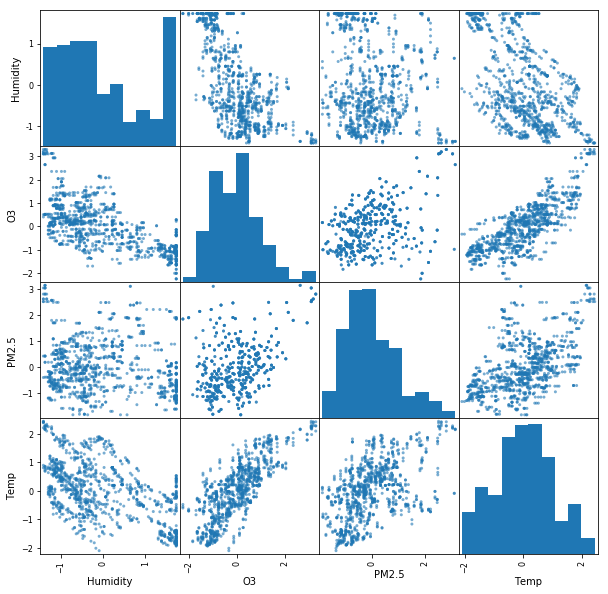

In [18]:
scatter_matrix(opth, alpha=0.6, figsize=(10,10), diagonal='hist')
plt.show()

## Linear Least Squares - no errors

### (1)  D(750) / D(1000)   --||vs||--   O3, PM2.5, Temps, Humid

In [19]:
ind  = np.arange(len(D_750_1000))
sol1  = np.linalg.lstsq(aq_opth1[ind],D_750_1000[ind], rcond=None)
pred1 = np.dot(aq_opth1[ind],sol1[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - sol1[1] / (len(D_750_1000) * D_750_1000.var())
print("sol = ", sol1)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([ 2.23908934e-01, -2.18795555e-01,  2.60641672e-01, -3.13391496e-01,
        3.85025130e-16]), array([641.46411423]), 5, array([53.49404632, 33.19638535, 30.90986022, 19.61546801, 14.35969933]))
r2  =  [0.41790915]


### (2)  D(750) / D(900)   --||vs||--   O3, PM2.5, Temps, Humid

In [20]:
ind  = np.arange(len(D_750_900))
sol2  = np.linalg.lstsq(aq_opth1[ind],D_750_900[ind], rcond=None)
pred2 = np.dot(aq_opth1[ind],sol2[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - sol2[1] / (len(D_750_900) * D_750_900.var())
print("sol = ", sol2)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([ 2.22561829e-01, -2.18799088e-01,  2.70112530e-01, -3.00463834e-01,
        2.55011215e-16]), array([648.8319062]), 5, array([53.49404632, 33.19638535, 30.90986022, 19.61546801, 14.35969933]))
r2  =  [0.41122332]


### (3)  D(750) / D(900-1000)   --||vs||--   O3, PM2.5, Temps, Humid

In [21]:
ind  = np.arange(len(D_750_900m1000))
sol3  = np.linalg.lstsq(aq_opth1[ind],D_750_900m1000[ind], rcond=None)
pred3 = np.dot(aq_opth1[ind],sol3[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - sol3[1] / (len(D_750_900m1000) * D_750_900m1000.var())
print("sol = ", sol3)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([ 2.20898898e-01, -2.18495186e-01,  2.70246095e-01, -3.03616740e-01,
        3.11030072e-16]), array([646.74647973]), 5, array([53.49404632, 33.19638535, 30.90986022, 19.61546801, 14.35969933]))
r2  =  [0.41311572]


### (4)  D(700-800) / D(900-1000)   --||vs||--   O3, PM2.5, Temps, Humid

In [22]:
ind  = np.arange(len(D_700m800_900m1000))
sol4  = np.linalg.lstsq(aq_opth1[ind],D_700m800_900m1000[ind], rcond=None)
pred4 = np.dot(aq_opth1[ind],sol4[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - sol4[1] / (len(D_700m800_900m1000) * D_700m800_900m1000.var())
print("sol = ", sol4)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([ 2.36309439e-01, -2.18945548e-01,  1.98975272e-01, -3.37508776e-01,
        2.25747633e-17]), array([661.28278811]), 5, array([53.49404632, 33.19638535, 30.90986022, 19.61546801, 14.35969933]))
r2  =  [0.39992487]


### (5)  D(700-900) / D(400-700)   --||vs||--   O3, PM2.5, Temps, Humid

In [23]:
ind  = np.arange(len(D_700m900_400m700))
sol5  = np.linalg.lstsq(aq_opth1[ind],D_700m900_400m700[ind], rcond=None)
pred5 = np.dot(aq_opth1[ind],sol5[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - sol5[1] / (len(D_700m900_400m700) * D_700m900_400m700.var())
print("sol = ", sol5)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([ 1.65880208e-01, -4.99766743e-02,  3.34438870e-01,  3.95605175e-02,
       -1.41928373e-15]), array([898.82038324]), 5, array([53.49404632, 33.19638535, 30.90986022, 19.61546801, 14.35969933]))
r2  =  [0.18437352]


### (6)  D(700-1000) / D(400-700)   --||vs||--   O3, PM2.5, Temps, Humid

In [24]:
ind  = np.arange(len(D_700m1000_400m700))
sol6  = np.linalg.lstsq(aq_opth1[ind],D_700m1000_400m700[ind], rcond=None)
pred6 = np.dot(aq_opth1[ind],sol6[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - sol6[1] / (len(D_700m1000_400m700) * D_700m1000_400m700.var())
print("sol = ", sol6)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([ 6.02815078e-02,  2.63497891e-02,  2.89970296e-01,  2.14015302e-01,
       -7.69057388e-16]), array([1009.7071979]), 5, array([53.49404632, 33.19638535, 30.90986022, 19.61546801, 14.35969933]))
r2  =  [0.08375027]


#### Plot all together

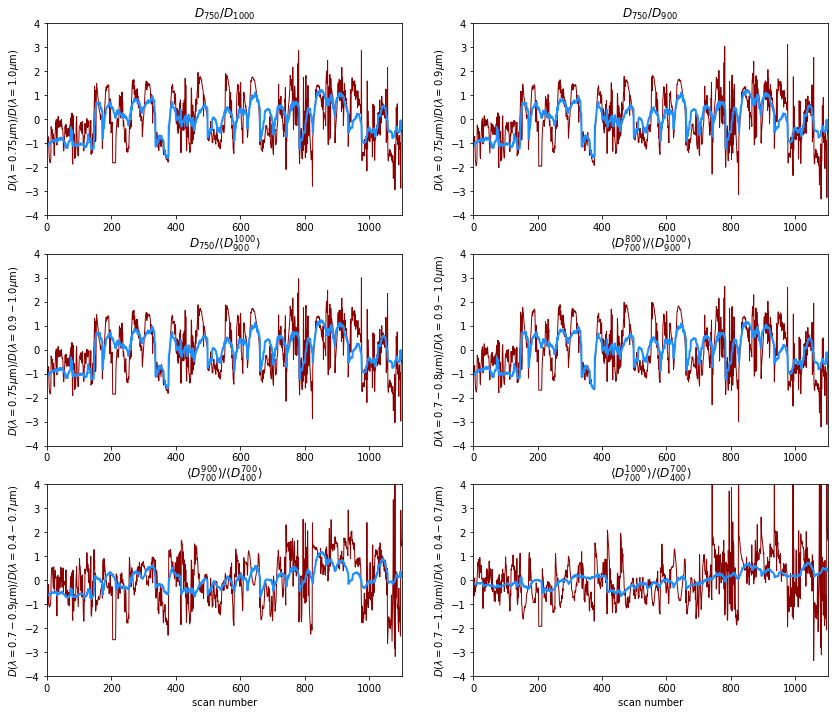

In [25]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14,12))

ax1.plot(D_750_1000,color="darkred",lw=1)
ax1.plot(pred1,color="dodgerblue",lw=2)
ax1.set_ylim(-4,4)
ax1.set_xlim(0,pred1.size)
#ax1.set_xlabel("scan number")
ax1.set_ylabel(r'$D(\lambda=0.75\mu$m$)/D(\lambda=1.0\mu$m$)$')
ax1.set_title(r'$D_{750}/D_{1000}$')

ax2.plot(D_750_900,color="darkred",lw=1)
ax2.plot(pred2,color="dodgerblue",lw=2)
ax2.set_ylim(-4,4)
ax2.set_xlim(0,pred2.size)
#ax2.set_xlabel("scan number")
ax2.set_ylabel(r'$D(\lambda=0.75\mu$m$)/D(\lambda=0.9\mu$m$)$')
ax2.set_title(r'$D_{750}/D_{900}$')

ax3.plot(D_750_900m1000,color="darkred",lw=1)
ax3.plot(pred3,color="dodgerblue",lw=2)
ax3.set_ylim(-4,4)
ax3.set_xlim(0,pred3.size)
#ax.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax3.set_ylabel(r'$D(\lambda=0.75\mu$m$)/D(\lambda=0.9-1.0\mu$m$)$')
ax3.set_title(r'$D_{750}/\langle D_{900}^{1000} \rangle$')

ax4.plot(D_700m800_900m1000,color="darkred",lw=1)
ax4.plot(pred4,color="dodgerblue",lw=2)
ax4.set_ylim(-4,4)
ax4.set_xlim(0,pred4.size)
#ax4.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax4.set_ylabel(r'$D(\lambda=0.7-0.8\mu$m$)/D(\lambda=0.9-1.0\mu$m$)$')
ax4.set_title(r'$\langle D_{700}^{800} \rangle/\langle D_{900}^{1000} \rangle$')

ax5.plot(D_700m900_400m700,color="darkred",lw=1)
ax5.plot(pred5,color="dodgerblue",lw=2)
ax5.set_ylim(-4,4)
ax5.set_xlim(0,pred5.size)
ax5.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax5.set_ylabel(r'$D(\lambda=0.7-0.9\mu$m$)/D(\lambda=0.4-0.7\mu$m$)$')
ax5.set_title(r'$\langle D_{700}^{900} \rangle/\langle D_{400}^{700} \rangle$')

ax6.plot(D_700m1000_400m700,color="darkred",lw=1)
ax6.plot(pred6,color="dodgerblue",lw=2)
ax6.set_ylim(-4,4)
ax6.set_xlim(0,pred6.size)
ax6.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax6.set_ylabel(r'$D(\lambda=0.7-1.0\mu$m$)/D(\lambda=0.4-0.7\mu$m$)$')
ax6.set_title(r'$\langle D_{700}^{1000} \rangle/\langle D_{400}^{700} \rangle$')

plt.show()

### Signal Processing - Apply Median Filter

In [71]:
brightness = sp.signal.medfilt(D_750_1000, 25)

In [72]:
ind  = np.arange(len(brightness))
sol  = np.linalg.lstsq(aq_opth1[ind],brightness[ind], rcond=None)
pred = np.dot(aq_opth1[ind],sol1[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - sol[1] / (len(brightness) * brightness.var())
print("sol = ", sol)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([ 0.22520542, -0.14522992,  0.15905728, -0.30067406,  0.02843082]), array([288.92381695]), 5, array([53.49404632, 33.19638535, 30.90986022, 19.61546801, 14.35969933]))
r2  =  [0.55095783]


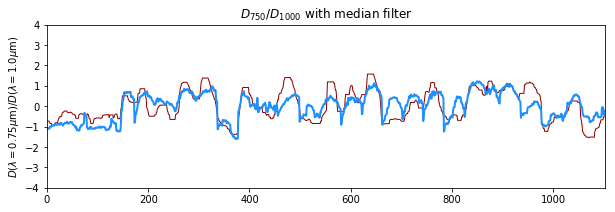

In [73]:
fig = plt.subplots(figsize=[10,3])
plt.plot(brightness,color="darkred",lw=1)
plt.plot(pred,color="dodgerblue",lw=2)
plt.ylim(-4,4)
plt.xlim(0,pred.size)
#ax1.set_xlabel("scan number")
plt.ylabel(r'$D(\lambda=0.75\mu$m$)/D(\lambda=1.0\mu$m$)$')
plt.title(r'$D_{750}/D_{1000}$ with median filter')
plt.show()

## Maximum Likelihood Estimation with brightness

$brightness = w_{O_3} * O_3 + w_{PM2.5} * PM2.5 + w_{temp} * Temp + w_{humid} * Humid + b + \epsilon$

$\epsilon$ is a Gaussian noise term such that:

observed = true + random.normal(0, $\epsilon$, number_of_observations)

In [74]:
# -- obtaining uncertainty for brightness
#brightness = brat[:,500]/brat[:,-1]
#brightness = D_700m900_400m700
#brightness = D_750_1000
diff = brightness[1:] - brightness[:-1]
berr = diff.std()/np.sqrt(2.0)
print("error in brightness = ", berr)

error in brightness =  0.07119055891711408


In [75]:
# -- obtaining uncertainty for air quality
templates  = np.vstack([o3,pm25,temps,humid,np.ones_like(o3)]).T
diff_air = templates[1:] - templates[:-1]
air_err = diff_air.std(0)/np.sqrt(2.0)
print("errors in air qaulity = ", air_err)

errors in air qaulity =  [0.17136478 0.21631062 0.12425874 0.11580156 0.        ]


In [76]:
brightness_err = np.full(brightness.shape, berr)
o3err = np.full(brightness.shape, air_err[0])
pm25err = np.full(brightness.shape, air_err[1])
temperr = np.full(brightness.shape, air_err[2])
humiderr = np.full(brightness.shape, air_err[3])
alphaerr = np.full(brightness.shape, air_err[4])
terr = np.vstack([o3err,pm25err,temperr,humiderr,alphaerr]).T

In [77]:
def log_prior(theta):
    beta_o3, beta_pm25, beta_temps, beta_humid, alpha, eps = theta
    if eps <= 0:
        return -np.inf
    return 0.0

def log_likelihood(theta, o3, pm25, temps, humid, y):
    beta_o3, beta_pm25, beta_temps, beta_humid, alpha, eps = theta
    model = beta_o3 * o3 + beta_pm25 * pm25 + beta_temps * temps + beta_humid * humid + alpha
    denom = eps ** 2
    lp = -0.5 * sum(((y - model) ** 2) / denom + np.log(denom) + np.log(2 * np.pi))
    return lp

def log_probability(theta, o3, pm25, temps, humid, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, o3, pm25, temps, humid, y)

In [82]:
# -- numerical optimum of likelihood function

from scipy.optimize import minimize

np.random.seed(314)
nll = lambda *args: -log_likelihood(*args)
initial = np.append(sol[0], berr)
result = minimize(nll, initial, args=(aq_opth1[:,0], aq_opth1[:,1], aq_opth1[:,2], 
                                    aq_opth1[:,3], brightness))
beta_o3_ml, beta_pm25_ml, beta_temps_ml, beta_humid_ml, alpha_ml, epsilon_ml = result.x

print("Maximum likelihood estimates:")
print("w_o3    =  {0:.5f}".format(beta_o3_ml))
print("w_pm25  = {0:.5f}".format(beta_pm25_ml))
print("w_temps =  {0:.5f}".format(beta_temps_ml))
print("w_humid = {0:.5f}".format(beta_humid_ml))
print("b       =  {0:.5f}".format(alpha_ml))
print("e       =  {0:.5f}".format(epsilon_ml))

Maximum likelihood estimates:
w_o3    =  0.22521
w_pm25  = -0.14523
w_temps =  0.15906
w_humid = -0.30067
b       =  0.02843
e       =  0.51204


### MCMC train on all instances

### MCMC

$brightness = w_{O_3} * O_3 + w_{PM2.5} * PM_{2.5} + w_{temp} * Temp + w_{humid} * Humid + b + \epsilon$

$\epsilon$ is Gaussian noise term such that:

brightness observed = true brightness + random.normal(0, $\epsilon$, number_of_observations)

In [83]:
nwalkers, ndim = 50, 6
p0 = result.x + 1e-4 * np.random.randn(nwalkers, ndim)

In [84]:
# -- Sample the distribution using emcee
# -- start by initializing the walkers in a small Gaussian ball around the maximum likelihood result
# -- then run 5000 steps of MCMC

import emcee

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                args=(aq_opth1[:,0], aq_opth1[:,1],
                                      aq_opth1[:,2], aq_opth1[:,3], brightness))
pos, prob, state = sampler.run_mcmc(p0, 5000)

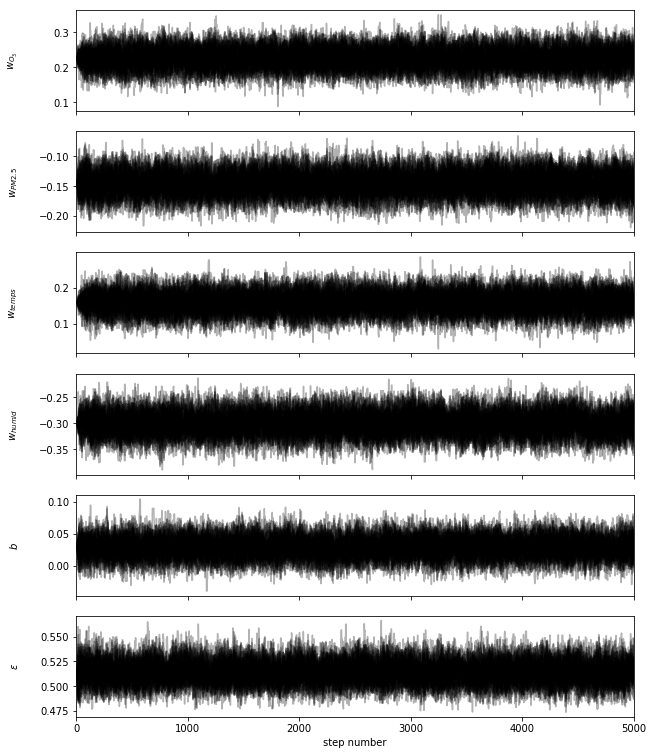

In [85]:
fig, axes = plt.subplots(ndim, figsize=(10, 13), sharex=True)
labels = [r'$w_{O_3}$', r'$w_{PM2.5}$', r'$w_{temps}$', r'$w_{humid}$', r'$b$', r'$\epsilon$']
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1].set_xlabel("step number")
plt.show()

In [86]:
tau = sampler.get_autocorr_time()
print(tau)

[56.38525929 60.10957798 56.28557586 57.97451338 57.18459541 63.68416424]


In [87]:
# -- discard initial 200 steps (~3 x tau)
# -- thin by 30 (about half the autocorrelation time)
# -- flatten chain

flat_samples = sampler.get_chain(discard=200, thin=30, flat=True)
print(flat_samples.shape)

(8000, 6)


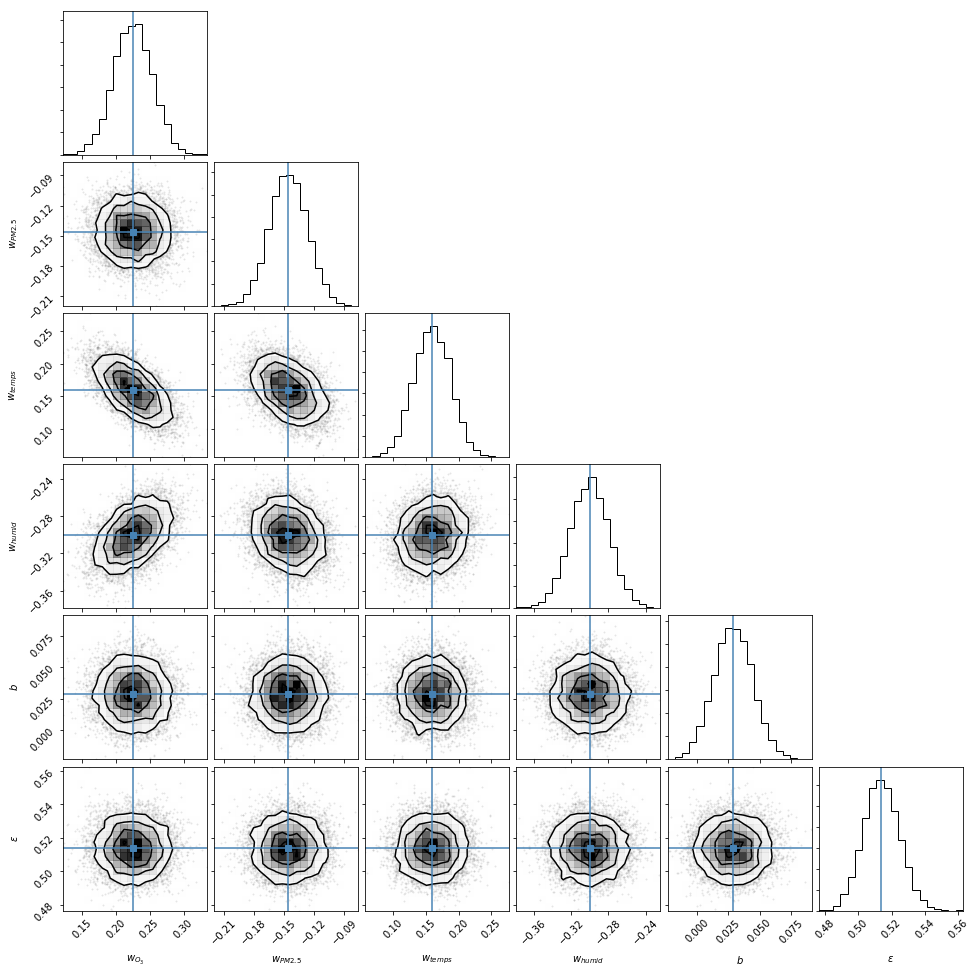

In [88]:
import corner

fig = corner.corner(flat_samples, labels=labels, truths=np.median(flat_samples, axis=0))

In [91]:
from IPython.display import display, Math

labels = ["w_{O_3}", "w_{PM2.5}", "w_{temps}", "w_{humid}", "b", "\epsilon"]
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

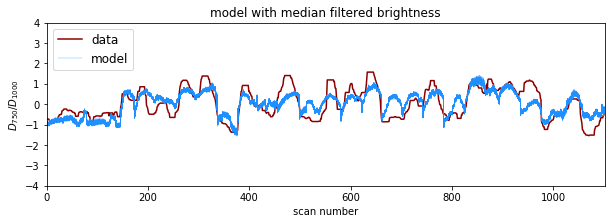

In [94]:
fig = plt.subplots(figsize=[10,3])
linb, = plt.plot(brightness,color="darkred",lw=1.5)
inds = np.random.randint(len(flat_samples), size=800)
for ind in inds:
    sample = flat_samples[ind]
    linp, = plt.plot(np.dot(aq_opth1, sample[:5]), color="dodgerblue", lw=0.3)
plt.ylim(-4, 4)
plt.xlim(0,pred5.size)
plt.xlabel("scan number")
#plt.ylabel(r'$\langle D_{700}^{900} \rangle / \langle D_{400}^{700} \rangle$')
plt.ylabel(r'$D_{750} / D_{1000}$')
plt.title('model with median filtered brightness')
plt.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)
plt.show()

In [95]:
# Getting 50th percentile values to use for prediction, and 16th and 84th differences for uncertainty
mvals = np.zeros(ndim)
err_vals = np.zeros(ndim)

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    mvals[i] = mcmc[1]
    err_vals[i] = (abs(q[0]) + abs(q[1])) / 2

print(mvals)
print(err_vals)

[ 0.22544073 -0.14572764  0.15932551 -0.3002447   0.02880411  0.5138689 ]
[0.02823746 0.01855816 0.02782156 0.02089225 0.01537093 0.01076985]


In [96]:
# calculate prediction and uncertainty
def err_mult(m, merr, x, xerr):
    err = abs(m * x) * np.sqrt((merr/m)**2 + (xerr/x)**2)
    return err

pred_tr = np.dot(aq_opth1, mvals[:5])
pred_tr_err = np.zeros(pred_tr.shape)

for i in range(aq_opth1.shape[0]):
    mO_err = err_mult(mvals[0], err_vals[0], aq_opth1[i,0], air_err[0])
    mp_err = err_mult(mvals[1], err_vals[1], aq_opth1[i,1], air_err[1])
    mt_err = err_mult(mvals[2], err_vals[2], aq_opth1[i,2], air_err[2])
    mh_err = err_mult(mvals[3], err_vals[3], aq_opth1[i,3], air_err[3])
    pred_tr_err[i] = np.linalg.norm(np.array([mO_err, mp_err, mt_err, mh_err, err_vals[4]]))

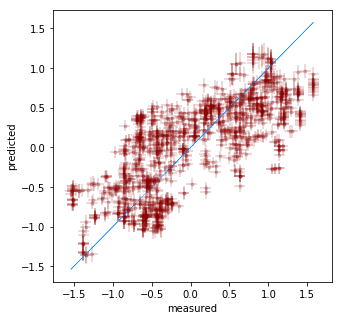

In [98]:
fig = plt.subplots(figsize=[5, 5])
linetr = plt.errorbar(brightness, pred_tr, xerr=np.full(brightness.shape, berr), 
                      yerr=pred_tr_err, fmt='.', color="darkred", alpha=0.2)
linlin, = plt.plot(brightness, brightness, color="dodgerblue", lw=0.5)
plt.xlabel('measured')
plt.ylabel('predicted')
#plt.ylim(-2,1.5)
#ax[i].legend([linetr,linete], ['training set', 'testing set'], loc='upper left')
plt.show()

#### reduced chi-squared per degree of freedom

In [99]:
def redchisqg(ydata, ymod, deg=2, sd=None):
    if np.any(sd == None):
        chisq = np.sum( (ydata-ymod)**2 )
    else:
        chisq = np.sum( ((ydata - ymod) / sd)**2 )
    
    # Number of degrees of freedom assuming 2 free parameters
    nu = ydata.size - deg
    
    return chisq/nu

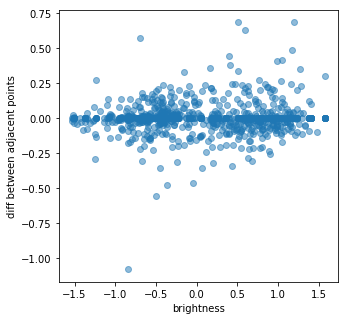

In [102]:
# -- obtaining uncertainties for measured

fig = plt.subplots(figsize=[5, 5])
diff = brightness[1:] - brightness[:-1]
plt.plot(brightness[1:], diff, 'o', alpha=0.5)
plt.xlabel('brightness')
plt.ylabel('diff between adjacent points')
plt.show()

In [103]:
berr = diff.std()/np.sqrt(2.0)
print("error in training brightness = ", berr)
#brightness_err = np.full(brightness.shape, berr)

error in training brightness =  0.07119055891711408


In [104]:
chisq_all_opth = redchisqg(brightness, pred_tr, deg=ndim-1, sd=np.full(brightness.shape, berr))

print("chi^2/dof = ", chisq_all_opth)

chi^2/dof =  51.96758440056689


### Signal Processing - Apply Gaussian Filter

In [106]:
brightness = gaussian_filter1d(D_750_1000, 1)

In [107]:
ind  = np.arange(len(brightness))
sol  = np.linalg.lstsq(aq_opth1[ind],brightness[ind], rcond=None)
pred = np.dot(aq_opth1[ind],sol1[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - sol[1] / (len(brightness) * brightness.var())
print("sol = ", sol)
#print("rsq = ", rsq)
print("r2  = ", r2)

sol =  (array([ 2.38597094e-01, -2.21188989e-01,  2.48101380e-01, -3.05088188e-01,
        3.57851803e-16]), array([459.21126315]), 5, array([53.49404632, 33.19638535, 30.90986022, 19.61546801, 14.35969933]))
r2  =  [0.49716158]


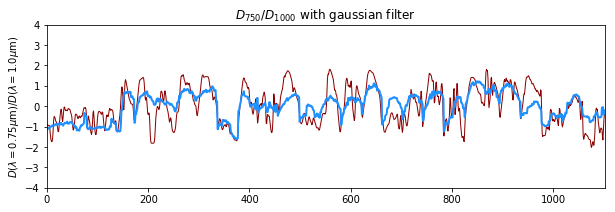

In [109]:
fig = plt.subplots(figsize=[10,3])
plt.plot(brightness,color="darkred",lw=1)
plt.plot(pred,color="dodgerblue",lw=2)
plt.ylim(-4,4)
plt.xlim(0,pred.size)
#ax1.set_xlabel("scan number")
plt.ylabel(r'$D(\lambda=0.75\mu$m$)/D(\lambda=1.0\mu$m$)$')
plt.title(r'$D_{750}/D_{1000}$ with gaussian filter')
plt.show()

## Maximum Likelihood Estimation with brightness

$brightness = w_{O_3} * O_3 + w_{PM2.5} * PM2.5 + w_{temp} * Temp + w_{humid} * Humid + b + \epsilon$

$\epsilon$ is a Gaussian noise term such that:

observed = true + random.normal(0, $\epsilon$, number_of_observations)

In [110]:
# -- obtaining uncertainty for brightness
#brightness = brat[:,500]/brat[:,-1]
#brightness = D_700m900_400m700
#brightness = D_750_1000
diff = brightness[1:] - brightness[:-1]
berr = diff.std()/np.sqrt(2.0)
print("error in brightness = ", berr)

error in brightness =  0.15607503623486485


In [111]:
# -- obtaining uncertainty for air quality
templates  = np.vstack([o3,pm25,temps,humid,np.ones_like(o3)]).T
diff_air = templates[1:] - templates[:-1]
air_err = diff_air.std(0)/np.sqrt(2.0)
print("errors in air qaulity = ", air_err)

errors in air qaulity =  [0.17136478 0.21631062 0.12425874 0.11580156 0.        ]


In [112]:
brightness_err = np.full(brightness.shape, berr)
o3err = np.full(brightness.shape, air_err[0])
pm25err = np.full(brightness.shape, air_err[1])
temperr = np.full(brightness.shape, air_err[2])
humiderr = np.full(brightness.shape, air_err[3])
alphaerr = np.full(brightness.shape, air_err[4])
terr = np.vstack([o3err,pm25err,temperr,humiderr,alphaerr]).T

In [113]:
def log_prior(theta):
    beta_o3, beta_pm25, beta_temps, beta_humid, alpha, eps = theta
    if eps <= 0:
        return -np.inf
    return 0.0

def log_likelihood(theta, o3, pm25, temps, humid, y):
    beta_o3, beta_pm25, beta_temps, beta_humid, alpha, eps = theta
    model = beta_o3 * o3 + beta_pm25 * pm25 + beta_temps * temps + beta_humid * humid + alpha
    denom = eps ** 2
    lp = -0.5 * sum(((y - model) ** 2) / denom + np.log(denom) + np.log(2 * np.pi))
    return lp

def log_probability(theta, o3, pm25, temps, humid, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, o3, pm25, temps, humid, y)

In [114]:
# -- numerical optimum of likelihood function

from scipy.optimize import minimize

np.random.seed(314)
nll = lambda *args: -log_likelihood(*args)
initial = np.append(sol[0], berr)
result = minimize(nll, initial, args=(aq_opth1[:,0], aq_opth1[:,1], aq_opth1[:,2], 
                                    aq_opth1[:,3], brightness))
beta_o3_ml, beta_pm25_ml, beta_temps_ml, beta_humid_ml, alpha_ml, epsilon_ml = result.x

print("Maximum likelihood estimates:")
print("w_o3    =  {0:.5f}".format(beta_o3_ml))
print("w_pm25  = {0:.5f}".format(beta_pm25_ml))
print("w_temps =  {0:.5f}".format(beta_temps_ml))
print("w_humid = {0:.5f}".format(beta_humid_ml))
print("b       =  {0:.5f}".format(alpha_ml))
print("e       =  {0:.5f}".format(epsilon_ml))

Maximum likelihood estimates:
w_o3    =  0.23860
w_pm25  = -0.22119
w_temps =  0.24810
w_humid = -0.30509
b       =  0.00000
e       =  0.64553


### MCMC train on all instances

### MCMC

$brightness = w_{O_3} * O_3 + w_{PM2.5} * PM_{2.5} + w_{temp} * Temp + w_{humid} * Humid + b + \epsilon$

$\epsilon$ is Gaussian noise term such that:

brightness observed = true brightness + random.normal(0, $\epsilon$, number_of_observations)

In [115]:
nwalkers, ndim = 50, 6
p0 = result.x + 1e-4 * np.random.randn(nwalkers, ndim)

In [116]:
# -- Sample the distribution using emcee
# -- start by initializing the walkers in a small Gaussian ball around the maximum likelihood result
# -- then run 5000 steps of MCMC

import emcee

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                args=(aq_opth1[:,0], aq_opth1[:,1],
                                      aq_opth1[:,2], aq_opth1[:,3], brightness))
pos, prob, state = sampler.run_mcmc(p0, 5000)

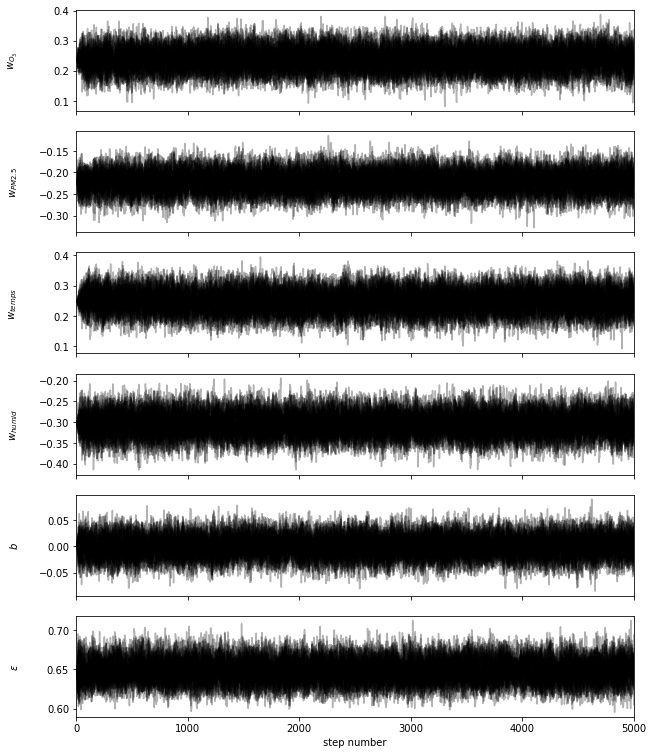

In [117]:
fig, axes = plt.subplots(ndim, figsize=(10, 13), sharex=True)
labels = [r'$w_{O_3}$', r'$w_{PM2.5}$', r'$w_{temps}$', r'$w_{humid}$', r'$b$', r'$\epsilon$']
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1].set_xlabel("step number")
plt.show()

In [118]:
tau = sampler.get_autocorr_time()
print(tau)

[59.30170197 61.46122114 63.19414456 59.03132262 61.03103158 62.50819262]


In [119]:
# -- discard initial 200 steps (~3 x tau)
# -- thin by 30 (about half the autocorrelation time)
# -- flatten chain

flat_samples = sampler.get_chain(discard=200, thin=30, flat=True)
print(flat_samples.shape)

(8000, 6)


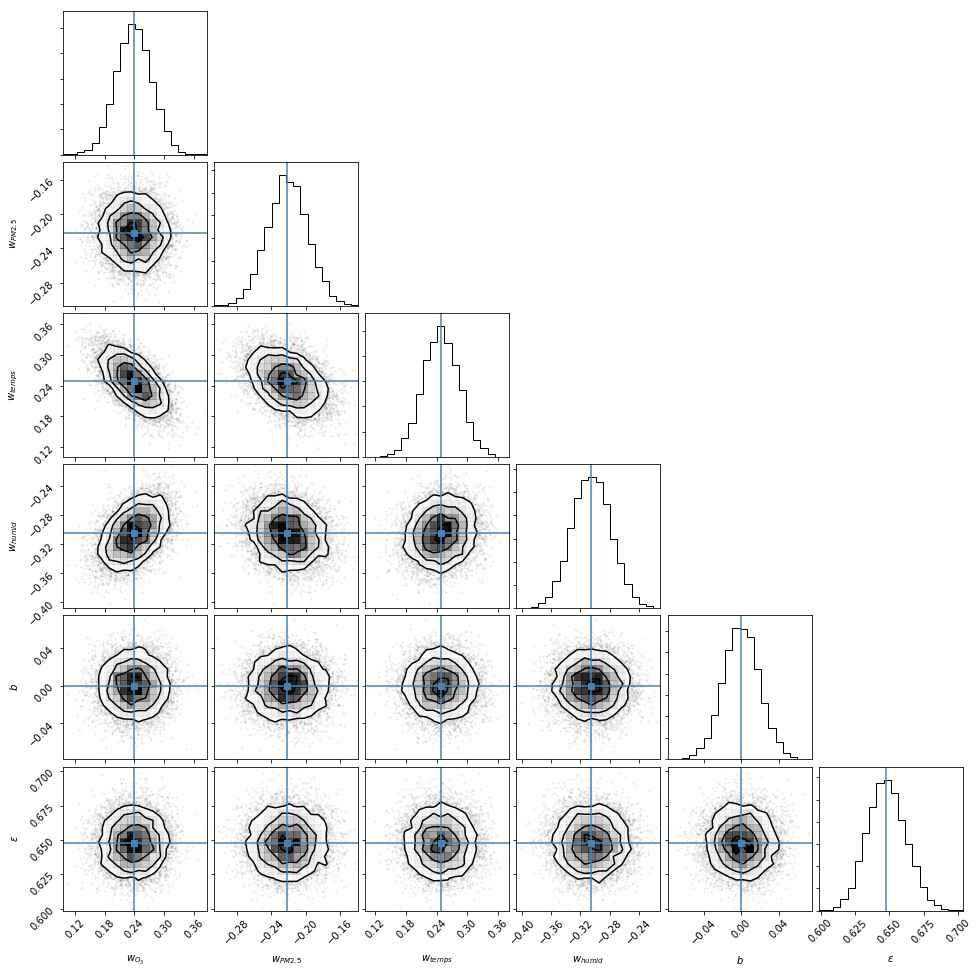

In [120]:
import corner

fig = corner.corner(flat_samples, labels=labels, truths=np.median(flat_samples, axis=0))

In [121]:
from IPython.display import display, Math

labels = ["w_{O_3}", "w_{PM2.5}", "w_{temps}", "w_{humid}", "b", "\epsilon"]
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

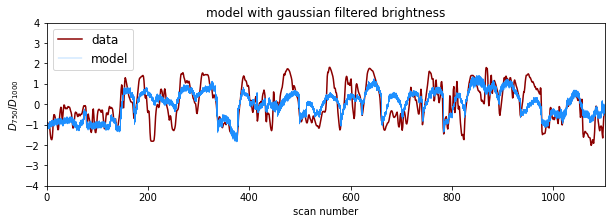

In [122]:
fig = plt.subplots(figsize=[10,3])
linb, = plt.plot(brightness,color="darkred",lw=1.5)
inds = np.random.randint(len(flat_samples), size=800)
for ind in inds:
    sample = flat_samples[ind]
    linp, = plt.plot(np.dot(aq_opth1, sample[:5]), color="dodgerblue", lw=0.3)
plt.ylim(-4, 4)
plt.xlim(0,pred5.size)
plt.xlabel("scan number")
#plt.ylabel(r'$\langle D_{700}^{900} \rangle / \langle D_{400}^{700} \rangle$')
plt.ylabel(r'$D_{750} / D_{1000}$')
plt.title('model with gaussian filtered brightness')
plt.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)
plt.show()

In [123]:
# Getting 50th percentile values to use for prediction, and 16th and 84th differences for uncertainty
mvals = np.zeros(ndim)
err_vals = np.zeros(ndim)

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    mvals[i] = mcmc[1]
    err_vals[i] = (abs(q[0]) + abs(q[1])) / 2

print(mvals)
print(err_vals)

[ 2.38524014e-01 -2.21356066e-01  2.47937871e-01 -3.05125876e-01
  5.96103079e-05  6.47570169e-01]
[0.03543047 0.02315395 0.03515604 0.02644521 0.01898628 0.01408743]


In [124]:
# calculate prediction and uncertainty
def err_mult(m, merr, x, xerr):
    err = abs(m * x) * np.sqrt((merr/m)**2 + (xerr/x)**2)
    return err

pred_tr = np.dot(aq_opth1, mvals[:5])
pred_tr_err = np.zeros(pred_tr.shape)

for i in range(aq_opth1.shape[0]):
    mO_err = err_mult(mvals[0], err_vals[0], aq_opth1[i,0], air_err[0])
    mp_err = err_mult(mvals[1], err_vals[1], aq_opth1[i,1], air_err[1])
    mt_err = err_mult(mvals[2], err_vals[2], aq_opth1[i,2], air_err[2])
    mh_err = err_mult(mvals[3], err_vals[3], aq_opth1[i,3], air_err[3])
    pred_tr_err[i] = np.linalg.norm(np.array([mO_err, mp_err, mt_err, mh_err, err_vals[4]]))

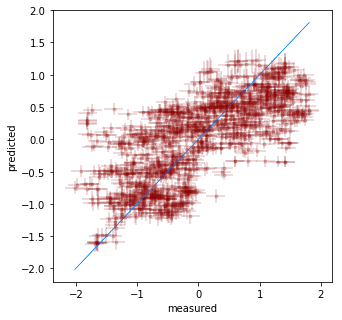

In [125]:
fig = plt.subplots(figsize=[5, 5])
linetr = plt.errorbar(brightness, pred_tr, xerr=np.full(brightness.shape, berr), 
                      yerr=pred_tr_err, fmt='.', color="darkred", alpha=0.2)
linlin, = plt.plot(brightness, brightness, color="dodgerblue", lw=0.5)
plt.xlabel('measured')
plt.ylabel('predicted')
#plt.ylim(-2,1.5)
#ax[i].legend([linetr,linete], ['training set', 'testing set'], loc='upper left')
plt.show()

#### reduced chi-squared per degree of freedom

In [126]:
def redchisqg(ydata, ymod, deg=2, sd=None):
    if np.any(sd == None):
        chisq = np.sum( (ydata-ymod)**2 )
    else:
        chisq = np.sum( ((ydata - ymod) / sd)**2 )
    
    # Number of degrees of freedom assuming 2 free parameters
    nu = ydata.size - deg
    
    return chisq/nu

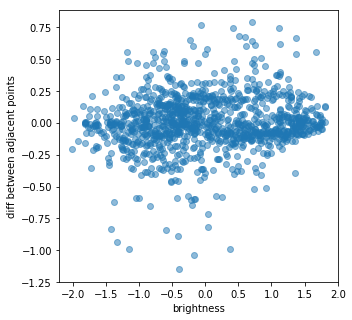

In [127]:
# -- obtaining uncertainties for measured

fig = plt.subplots(figsize=[5, 5])
diff = brightness[1:] - brightness[:-1]
plt.plot(brightness[1:], diff, 'o', alpha=0.5)
plt.xlabel('brightness')
plt.ylabel('diff between adjacent points')
plt.show()

In [128]:
berr = diff.std()/np.sqrt(2.0)
print("error in training brightness = ", berr)
#brightness_err = np.full(brightness.shape, berr)

error in training brightness =  0.15607503623486485


In [134]:
chisq_all_opth = redchisqg(brightness, pred_tr, deg=ndim-1, sd=np.full(brightness.shape, berr))

print("chi^2/dof = ", chisq_all_opth)

chi^2/dof =  17.184588207263293


#### split sample into 80% training and 20% testing

In [ ]:
#from sklearn.model_selection import train_test_split

#aq_tr, aq_te, br_tr, br_te = train_test_split(templates, brightness, test_size=0.2, random_state=314)

In [ ]:
#print("total # of instances: ", len(brightness))
#print("# training instances: ", len(br_tr))
#print("# testing instances : ", len(br_te))
#print("# features (incl. 1): ", aq_tr.shape[1])

## 5-fold cross validation

In [ ]:
from sklearn.model_selection import KFold

n_folds = 5
kf = KFold(n_splits=n_folds, random_state=55)

aq_tr = {}
aq_te = {}
br_tr = {}
br_te = {}

i=0
for tr_ind, te_ind in kf.split(brightness):
    print(len(tr_ind), len(te_ind))
    aq_tr[i] = aq_opth1[tr_ind]
    aq_te[i] = aq_opth1[te_ind]
    br_tr[i] = brightness[tr_ind]
    br_te[i] = brightness[te_ind]
    i+=1

## MCMC

$brightness = w_{O_3} * O_3 + w_{PM2.5} * PM_{2.5} + w_{temp} * Temp + w_{humid} * Humid + b + \epsilon$

$\epsilon$ is Gaussian noise term such that:

brightness observed = true brightness + random.normal(0, $\epsilon$, number_of_observations)

In [ ]:
nwalkers, ndim = 50, 6
p0 = result.x + 1e-4 * np.random.randn(nwalkers, ndim)

In [ ]:
# -- Sample the distribution using emcee
# -- start by initializing the walkers in a small Gaussian ball around the maximum likelihood result
# -- then run 5000 steps of MCMC

import emcee

sampler = {}

for i in range(n_folds):
    sampler[i] = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                       args=(aq_tr[i][:,0], aq_tr[i][:,1],
                                             aq_tr[i][:,2], aq_tr[i][:,3], br_tr[i]))
    pos, prob, state = sampler[i].run_mcmc(p0, 5000)

#sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(aq_tr[:,0],
#                                                              aq_tr[:,1],
#                                                              aq_tr[:,2],
#                                                              aq_tr[:,3],
#                                                              br_tr))
#pos, prob, state = sampler.run_mcmc(p0, 5000)

In [ ]:
fig, axes = plt.subplots(ndim, n_folds, figsize=(20, 10), sharex=True)
labels = [r'$w_{O_3}$', r'$w_{PM2.5}$', r'$w_{temps}$', r'$w_{humid}$', r'$b$', r'$\epsilon$']
for j in range(n_folds):
    samples = sampler[j].get_chain()
    for i in range(ndim):
        ax = axes[i, j]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
    
#axes[:,-1].set_xlabel("step number")
plt.show()

In [ ]:
for j in range(n_folds):
    tau = sampler[j].get_autocorr_time()
    print(tau)

In [ ]:
# -- discard initial 200 steps (~3 x tau)
# -- thin by 30 (about half the autocorrelation time)
# -- flatten chain

flat_samples = {}

for j in range(n_folds):
    flat_samples[j] = sampler[j].get_chain(discard=200, thin=30, flat=True)
    print(flat_samples[j].shape)

In [ ]:
stack_flat_samples = flat_samples[0]
for i in range(1,n_folds):
    stack_flat_samples = np.vstack([stack_flat_samples, flat_samples[i]])
print(stack_flat_samples.shape)

In [ ]:
import corner

fig = corner.corner(stack_flat_samples, labels=labels, truths=np.median(stack_flat_samples, axis=0))

In [ ]:
import corner
for i in range(n_folds):
    fig = corner.corner(flat_samples[i], labels=labels, truths=np.median(flat_samples[i], axis=0))

In [ ]:
from IPython.display import display, Math

labels = ["w_{O_3}", "w_{PM2.5}", "w_{temps}", "w_{humid}", "b", "\epsilon"]
for j in range(n_folds):
    print("Fold-",j)
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[j][:,i], [16, 50, 84])
        q = np.diff(mcmc)
        txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        display(Math(txt))
    print("")

In [ ]:
fig, ax = plt.subplots(n_folds, figsize=[10,10])
fig.subplots_adjust(0.125,0.15,0.95,0.9)
for i in range(n_folds):
    linb, = ax[i].plot(brightness,color="darkred",lw=1)
    inds = np.random.randint(len(flat_samples[i]), size=800)
    for ind in inds:
        sample = flat_samples[i][ind]
        linp, = ax[i].plot(np.dot(aq_opth1, sample[:5]), color="dodgerblue", lw=0.3)
    ax[i].set_ylim(-4, 4)
    ax[i].set_xlim(0,pred5.size)
    ax[i].set_xlabel("scan number")
    #ax[i].set_ylabel(r'$\langle D_{700}^{900} \rangle / \langle D_{400}^{700} \rangle$')
    ax[i].set_ylabel(r'$D_{750} / D_{1000}$')
    ax[i].legend([linb,linp],["data","model"],loc="upper left",fontsize=12)
plt.show()

In [ ]:
# Getting 50th percentile values to use for prediction, and 16th and 84th differences for uncertainty
mvals = np.zeros((n_folds, ndim))
err_vals = np.zeros((n_folds, ndim))

for j in range(n_folds):
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[j][:,i], [16, 50, 84])
        q = np.diff(mcmc)
        mvals[j, i] = mcmc[1]
        err_vals[j, i] = (abs(q[0]) + abs(q[1])) / 2

print(mvals)
print(err_vals)

In [ ]:
# calculate prediction and uncertainty
def err_mult(m, merr, x, xerr):
    err = abs(m * x) * np.sqrt((merr/m)**2 + (xerr/x)**2)
    return err

pred_tr = {}
pred_te = {}
pred_tr_err = {}
pred_te_err = {}

for j in range(n_folds):
    pred_tr[j] = np.dot(aq_tr[j], mvals[j,:5])
    pred_te[j] = np.dot(aq_te[j], mvals[j,:5])
    pred_tr_err[j] = np.zeros(pred_tr[j].shape)
    pred_te_err[j] = np.zeros(pred_te[j].shape)

    for i in range(aq_tr[j].shape[0]):
        mO_err = err_mult(mvals[j,0], err_vals[j,0], aq_tr[j][i,0], air_err[0])
        mp_err = err_mult(mvals[j,1], err_vals[j,1], aq_tr[j][i,1], air_err[1])
        mt_err = err_mult(mvals[j,2], err_vals[j,2], aq_tr[j][i,2], air_err[2])
        mh_err = err_mult(mvals[j,3], err_vals[j,3], aq_tr[j][i,3], air_err[3])
        pred_tr_err[j][i] = np.linalg.norm(np.array([mO_err, mp_err, mt_err, mh_err, err_vals[j,4]]))

    for i in range(aq_te[j].shape[0]):
        mO_err = err_mult(mvals[j,0], err_vals[j,0], aq_te[j][i,0], air_err[0])
        mp_err = err_mult(mvals[j,1], err_vals[j,1], aq_te[j][i,1], air_err[1])
        mt_err = err_mult(mvals[j,2], err_vals[j,2], aq_te[j][i,2], air_err[2])
        mh_err = err_mult(mvals[j,3], err_vals[j,3], aq_te[j][i,3], air_err[3])
        pred_te_err[j][i] = np.linalg.norm(np.array([mO_err, mp_err, mt_err, mh_err, err_vals[j,4]]))

In [ ]:
fig, ax = plt.subplots(n_folds, figsize=[5, 20])
for i in range(n_folds):
    linetr = ax[i].errorbar(br_tr[i], pred_tr[i], xerr=np.full(br_tr[i].shape, berr), 
                          yerr=pred_tr_err[i], fmt='.', color="orange", alpha=0.1)
    linete = ax[i].errorbar(br_te[i], pred_te[i], xerr=np.full(br_te[i].shape, berr), 
                          yerr=pred_te_err[i], fmt='.', color="darkred", alpha=0.5)
    linlin, = ax[i].plot(br_te[i], br_te[i], color="dodgerblue", lw=0.5)
    ax[i].set_xlabel('measured')
    ax[i].set_ylabel('predicted')
    ax[i].legend([linetr,linete], ['training set', 'testing set'], loc='upper left')
plt.show()

#### reduced chi-squared per degree of freedom

In [ ]:
def redchisqg(ydata, ymod, deg=2, sd=None):
    if np.any(sd == None):
        chisq = np.sum( (ydata-ymod)**2 )
    else:
        chisq = np.sum( ((ydata - ymod) / sd)**2 )
    
    # Number of degrees of freedom assuming 2 free parameters
    nu = ydata.size - deg
    
    return chisq/nu

In [ ]:
# -- obtaining uncertainties for measured

fig = plt.subplots(figsize=[5, 5])
diff = brightness[1:] - brightness[:-1]
plt.plot(brightness[1:], diff, 'o', alpha=0.5)
plt.show()

In [ ]:
berr = diff.std()/np.sqrt(2.0)
print("error in training brightness = ", berr)
#brightness_err = np.full(brightness.shape, berr)

In [ ]:
chisq_tr_opth = []
chisq_te_opth = []
for i in range(n_folds):
    chisq_tr_opth = np.append(chisq_tr_opth, redchisqg(br_tr[i], pred_tr[i], deg=ndim-1, sd=np.full(br_tr[i].shape, berr)))
    chisq_te_opth = np.append(chisq_te_opth, redchisqg(br_te[i], pred_te[i], deg=ndim-1, sd=np.full(br_te[i].shape, berr)))

print("Training chi^2/dof = ", chisq_tr_opth, ", mean train = ", chisq_tr_opth.mean())
print("Testing chi^2/dof  = ", chisq_te_opth, ", mean test  = ", chisq_te_opth.mean())

### OLS to obtain log-likelihood scores and p-values

In [ ]:
import statsmodels.formula.api as sm

In [ ]:
b_opth = pd.DataFrame({'brightness': brightness, 'o3': o3,
          'pm25': pm25, 'temps': temps, 'humid':humid})
b_opth.describe()

In [ ]:
# build model
model = sm.ols('brightness ~ o3 + pm25 + temps + humid', data=b_opth)

# fit model to the data
result_opth = model.fit()

In [ ]:
# summarize model result
result_opth.summary()

---

# Without O3

In [ ]:
aq_pth1 = np.vstack([pm25,temps,humid,np.ones_like(o3)]).T

In [ ]:
ind  = np.arange(len(brightness))
sol  = np.linalg.lstsq(aq_pth1[ind],brightness[ind], rcond=None)
pred = np.dot(aq_pth1[ind],sol[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - sol[1] / (len(brightness) * brightness.var())
print("sol = ", sol)
#print("rsq = ", rsq)
print("r2  = ", r2)

In [ ]:
fig, ax = plt.subplots(figsize=[6.5,3.5])
fig.subplots_adjust(0.125,0.15,0.95,0.9)
linb, = ax.plot(brightness,color="darkred",lw=1)
linp, = ax.plot(pred,color="dodgerblue",lw=2)
ax.set_ylim(-4,4)
ax.set_xlim(0,pred.size)
ax.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
#ax.set_ylabel(r'$\langle D_{700}^{900} \rangle / \langle D_{400}^{700} \rangle$')
ax.set_ylabel(r'$D_{750} / D_{1000}$')
ax.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)
plt.show()

## Maximum Likelihood Estimation with brightness

$brightness = w_{PM2.5} * PM2.5 + w_{temp} * Temp + w_{humid} * Humid + b + \epsilon$

$\epsilon$ is a Gaussian noise term such that:

observed = true + random.normal(0, $\epsilon$, number_of_observations)

In [ ]:
def log_prior(theta):
    beta_pm25, beta_temps, beta_humid, alpha, eps = theta
    if eps <= 0:
        return -np.inf
    return 0.0

def log_likelihood(theta, pm25, temps, humid, y):
    beta_pm25, beta_temps, beta_humid, alpha, eps = theta
    model = beta_pm25 * pm25 + beta_temps * temps + beta_humid * humid + alpha
    denom = eps ** 2
    lp = -0.5 * sum(((y - model) ** 2) / denom + np.log(denom) + np.log(2 * np.pi))
    return lp

def log_probability(theta, pm25, temps, humid, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, pm25, temps, humid, y)

In [ ]:
# -- numerical optimum of likelihood function

from scipy.optimize import minimize

np.random.seed(314)
nll = lambda *args: -log_likelihood(*args)
initial = np.append(sol[0], berr)
result = minimize(nll, initial, args=(aq_pth1[:,0], aq_pth1[:,1], aq_pth1[:,2], brightness))
beta_pm25_ml, beta_temps_ml, beta_humid_ml, alpha_ml, epsilon_ml = result.x

print("Maximum likelihood estimates:")
print("w_pm25  = {0:.5f}".format(beta_pm25_ml))
print("w_temps =  {0:.5f}".format(beta_temps_ml))
print("w_humid = {0:.5f}".format(beta_humid_ml))
print("b       =  {0:.5f}".format(alpha_ml))
print("e       =  {0:.5f}".format(epsilon_ml))

### MCMC training on all instances

### MCMC

$brightness = w_{PM2.5} * PM2.5 + w_{temp} * Temp + w_{humid} * Humid + b + \epsilon$

$\epsilon$ is Gaussian noise term such that:

brightness observed = true brightness + random.normal(0, epsilon, number_of_observations)

In [ ]:
nwalkers, ndim = 50, 5
p0 = result.x + 1e-4 * np.random.randn(nwalkers, ndim)

In [ ]:
# -- Sample the distribution using emcee
# -- start by initializing the walkers in a small Gaussian ball around the maximum likelihood result
# -- then run 5000 steps of MCMC

import emcee

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                args=(aq_pth1[:,0], aq_pth1[:,1],
                                      aq_pth1[:,2], brightness))
pos, prob, state = sampler.run_mcmc(p0, 5000)

#sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(aq_tr[:,0],
#                                                              aq_tr[:,1],
#                                                              aq_tr[:,2],
#                                                              br_tr))
#pos, prob, state = sampler.run_mcmc(p0, 5000)

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 10), sharex=True)
labels = [r'$w_{PM2.5}$', r'$w_{temps}$', r'$w_{humid}$', r'$b$', r'$\epsilon$']
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1].set_xlabel("step number")
plt.show()

In [ ]:
tau = sampler.get_autocorr_time()
print(tau)

In [ ]:
# -- discard initial 150 steps (~3 x tau)
# -- thin by 25 (about half the autocorrelation time)
# -- flatten chain

flat_samples = sampler.get_chain(discard=150, thin=25, flat=True)
print(flat_samples.shape)

In [ ]:
import corner

fig = corner.corner(flat_samples, labels=labels, truths=np.median(flat_samples, axis=0))

In [ ]:
from IPython.display import display, Math

labels = ["w_{PM2.5}", "w_{temps}", "w_{humid}", "b", "\epsilon"]
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

In [ ]:
fig = plt.subplots(figsize=[10,3])
linb, = plt.plot(brightness,color="darkred",lw=1)
inds = np.random.randint(len(flat_samples), size=800)
for ind in inds:
    sample = flat_samples[ind]
    linp, = plt.plot(np.dot(aq_pth1, sample[:4]), color="dodgerblue", lw=0.3)
plt.ylim(-4, 4)
plt.xlim(0,pred5.size)
plt.xlabel("scan number")
plt.ylabel(r'$\langle D_{700}^{900} \rangle / \langle D_{400}^{700} \rangle$')
#ax[i].legend([linb,linp],["data","model"],loc="upper left",fontsize=12)
plt.show()

In [ ]:
# Getting 50th percentile values to use for prediction, and 16th and 84th differences for uncertainty
mvals = np.zeros(ndim)
err_vals = np.zeros(ndim)

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    mvals[i] = mcmc[1]
    err_vals[i] = (abs(q[0]) + abs(q[1])) / 2

print(mvals)
print(err_vals)

In [ ]:
# calculate prediction and uncertainty
def err_mult(m, merr, x, xerr):
    err = abs(m * x) * np.sqrt((merr/m)**2 + (xerr/x)**2)
    return err

pred_tr = np.dot(aq_pth1, mvals[:4])
pred_tr_err = np.zeros(pred_tr.shape)

for i in range(aq_pth1.shape[0]):
    mp_err = err_mult(mvals[0], err_vals[0], aq_pth1[i,0], air_err[0])
    mt_err = err_mult(mvals[1], err_vals[1], aq_pth1[i,1], air_err[1])
    mh_err = err_mult(mvals[2], err_vals[2], aq_pth1[i,2], air_err[2])
    pred_tr_err[i] = np.linalg.norm(np.array([mp_err, mt_err, mh_err, err_vals[3]]))

In [ ]:
fig = plt.subplots(figsize=[5,5])
linetr = plt.errorbar(brightness, pred_tr, xerr=np.full(brightness.shape, berr), 
                      yerr=pred_tr_err, fmt='.', color="darkred", alpha=0.2)
linlin, = plt.plot(brightness, brightness, color="dodgerblue", lw=0.5)
plt.xlabel('measured')
plt.ylabel('predicted')
plt.ylim(-1.5,1.5)
#plt.legend([linetr,linete], ['training set', 'testing set'], loc='upper left')
plt.show()

#### reduced chi-squared per degree of freedom

In [ ]:
chisq_all_pth = redchisqg(brightness, pred_tr, deg=ndim-1, sd=np.full(brightness.shape, berr))

print("Train chi^2/dof = ", chisq_all_pth)

In [ ]:
print("Delta mean chi^2/dof (with O3 - without O3) = ", round(chisq_all_opth - chisq_all_pth, 3))

#### split sample into 80% training and 20% testing

In [ ]:
#from sklearn.model_selection import train_test_split

#aq_tr, aq_te, br_tr, br_te = train_test_split(aq_pth1, brightness, test_size=0.2, random_state=314)

In [ ]:
#print("total # of instances: ", len(brightness))
#print("# training instances: ", len(br_tr))
#print("# testing instances : ", len(br_te))
#print("# features (incl. 1): ", aq_tr.shape[1])

### 5-fold cross validation

In [ ]:
from sklearn.model_selection import KFold

n_folds = 5
kf = KFold(n_splits=n_folds, random_state=321)

aq_tr = {}
aq_te = {}
br_tr = {}
br_te = {}

i=0
for tr_ind, te_ind in kf.split(brightness):
    print(len(tr_ind), len(te_ind))
    aq_tr[i] = aq_pth1[tr_ind]
    aq_te[i] = aq_pth1[te_ind]
    br_tr[i] = brightness[tr_ind]
    br_te[i] = brightness[te_ind]
    i+=1

## MCMC

$brightness = w_{PM2.5} * PM2.5 + w_{temp} * Temp + w_{humid} * Humid + b + \epsilon$

$\epsilon$ is Gaussian noise term such that:

brightness observed = true brightness + random.normal(0, epsilon, number_of_observations)

In [ ]:
nwalkers, ndim = 50, 5
p0 = result.x + 1e-4 * np.random.randn(nwalkers, ndim)

In [ ]:
# -- Sample the distribution using emcee
# -- start by initializing the walkers in a small Gaussian ball around the maximum likelihood result
# -- then run 5000 steps of MCMC

import emcee

sampler = {}

for i in range(n_folds):
    sampler[i] = emcee.EnsembleSampler(nwalkers, ndim, log_probability, 
                                       args=(aq_tr[i][:,0], aq_tr[i][:,1],
                                             aq_tr[i][:,2], br_tr[i]))
    pos, prob, state = sampler[i].run_mcmc(p0, 5000)

#sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(aq_tr[:,0],
#                                                              aq_tr[:,1],
#                                                              aq_tr[:,2],
#                                                              br_tr))
#pos, prob, state = sampler.run_mcmc(p0, 5000)

In [ ]:
fig, axes = plt.subplots(ndim, n_folds, figsize=(20, 10), sharex=True)
labels = [r'$w_{PM2.5}$', r'$w_{temps}$', r'$w_{humid}$', r'$b$', r'$\epsilon$']
for j in range(n_folds):
    samples = sampler[j].get_chain()
    for i in range(ndim):
        ax = axes[i, j]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
    
#axes[:,-1].set_xlabel("step number")
plt.show()

In [ ]:
for j in range(n_folds):
    tau = sampler[j].get_autocorr_time()
    print(tau)

In [ ]:
# -- discard initial 150 steps (~3 x tau)
# -- thin by 25 (about half the autocorrelation time)
# -- flatten chain

flat_samples = {}

for j in range(n_folds):
    flat_samples[j] = sampler[j].get_chain(discard=150, thin=25, flat=True)
    print(flat_samples[j].shape)

In [ ]:
stack_flat_samples = flat_samples[0]
for i in range(1,n_folds):
    stack_flat_samples = np.vstack([stack_flat_samples, flat_samples[i]])
print(stack_flat_samples.shape)

In [ ]:
import corner

fig = corner.corner(stack_flat_samples, labels=labels, truths=np.median(stack_flat_samples, axis=0))

In [ ]:
import corner
for i in range(n_folds):
    fig = corner.corner(flat_samples[i], labels=labels, truths=np.median(flat_samples[i], axis=0))

In [ ]:
from IPython.display import display, Math

labels = ["w_{PM2.5}", "w_{temps}", "w_{humid}", "b", "\epsilon"]
for j in range(n_folds):
    print("Fold-",j)
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[j][:,i], [16, 50, 84])
        q = np.diff(mcmc)
        txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        display(Math(txt))
    print("")

In [ ]:
fig, ax = plt.subplots(n_folds, figsize=[10,10])
fig.subplots_adjust(0.125,0.15,0.95,0.9)
for i in range(n_folds):
    linb, = ax[i].plot(brightness,color="darkred",lw=1)
    inds = np.random.randint(len(flat_samples[i]), size=800)
    for ind in inds:
        sample = flat_samples[i][ind]
        linp, = ax[i].plot(np.dot(aq_pth1, sample[:4]), color="dodgerblue", lw=0.3)
    ax[i].set_ylim(-4, 4)
    ax[i].set_xlim(0,pred5.size)
    ax[i].set_xlabel("scan number")
    #ax[i].set_ylabel(r'$\langle D_{700}^{900} \rangle / \langle D_{400}^{700} \rangle$')
    ax[i].set_ylabel(r'$D_{750} / D_{1000}$')
    #ax[i].legend([linb,linp],["data","model"],loc="upper left",fontsize=12)
plt.show()

In [ ]:
# Getting 50th percentile values to use for prediction, and 16th and 84th differences for uncertainty
mvals = np.zeros((n_folds, ndim))
err_vals = np.zeros((n_folds, ndim))

for j in range(n_folds):
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[j][:,i], [16, 50, 84])
        q = np.diff(mcmc)
        mvals[j, i] = mcmc[1]
        err_vals[j, i] = (abs(q[0]) + abs(q[1])) / 2

print(mvals)
print(err_vals)

In [ ]:
# calculate prediction and uncertainty
def err_mult(m, merr, x, xerr):
    err = abs(m * x) * np.sqrt((merr/m)**2 + (xerr/x)**2)
    return err

pred_tr = {}
pred_te = {}
pred_tr_err = {}
pred_te_err = {}

for j in range(n_folds):
    pred_tr[j] = np.dot(aq_tr[j], mvals[j,:4])
    pred_te[j] = np.dot(aq_te[j], mvals[j,:4])
    pred_tr_err[j] = np.zeros(pred_tr[j].shape)
    pred_te_err[j] = np.zeros(pred_te[j].shape)

    for i in range(aq_tr[j].shape[0]):
        mp_err = err_mult(mvals[j,0], err_vals[j,0], aq_tr[j][i,0], air_err[0])
        mt_err = err_mult(mvals[j,1], err_vals[j,1], aq_tr[j][i,1], air_err[1])
        mh_err = err_mult(mvals[j,2], err_vals[j,2], aq_tr[j][i,2], air_err[2])
        pred_tr_err[j][i] = np.linalg.norm(np.array([mp_err, mt_err, mh_err, err_vals[j,3]]))

    for i in range(aq_te[j].shape[0]):
        mp_err = err_mult(mvals[j,0], err_vals[j,0], aq_te[j][i,0], air_err[0])
        mt_err = err_mult(mvals[j,1], err_vals[j,1], aq_te[j][i,1], air_err[1])
        mh_err = err_mult(mvals[j,2], err_vals[j,2], aq_te[j][i,2], air_err[2])
        pred_te_err[j][i] = np.linalg.norm(np.array([mp_err, mt_err, mh_err, err_vals[j,3]]))

In [ ]:
fig, ax = plt.subplots(n_folds, figsize=[5, 20])
for i in range(n_folds):
    linetr = ax[i].errorbar(br_tr[i], pred_tr[i], xerr=np.full(br_tr[i].shape, berr), 
                          yerr=pred_tr_err[i], fmt='.', color="orange", alpha=0.1)
    linete = ax[i].errorbar(br_te[i], pred_te[i], xerr=np.full(br_te[i].shape, berr), 
                          yerr=pred_te_err[i], fmt='.', color="darkred", alpha=0.5)
    linlin, = ax[i].plot(br_te[i], br_te[i], color="dodgerblue", lw=0.5)
    ax[i].set_xlabel('measured')
    ax[i].set_ylabel('predicted')
    ax[i].legend([linetr,linete], ['training set', 'testing set'], loc='upper left')
plt.show()

#### reduced chi-squared per degree of freedom

In [ ]:
def redchisqg(ydata, ymod, deg=2, sd=None):
    if np.any(sd == None):
        chisq = np.sum( (ydata-ymod)**2 )
    else:
        chisq = np.sum( ((ydata - ymod) / sd)**2 )
    
    # Number of degrees of freedom assuming 2 free parameters
    nu = ydata.size - deg
    
    return chisq/nu

In [ ]:
chisq_tr_pth = []
chisq_te_pth = []
for i in range(n_folds):
    chisq_tr_pth = np.append(chisq_tr_pth, redchisqg(br_tr[i], pred_tr[i], deg=ndim-1, sd=np.full(br_tr[i].shape, berr)))
    chisq_te_pth = np.append(chisq_te_pth, redchisqg(br_te[i], pred_te[i], deg=ndim-1, sd=np.full(br_te[i].shape, berr)))

print("Train chi^2/dof = ", chisq_tr_pth, ", mean train = ", chisq_tr_pth.mean())
print("Test chi^2/dof  = ", chisq_te_pth, ", mean test  = ", chisq_te_pth.mean())

In [ ]:
print("Delta mean chi^2/dof (with O3 - without O3)")
print("Training = {0:.3f}".format(chisq_tr_opth.mean() - chisq_tr_pth.mean()))
print("Testing  = {0:.3f}".format(chisq_te_opth.mean() - chisq_te_pth.mean()))

#### OLS to obtain log-likelihood scores and p-values

In [ ]:
# build model
model = sm.ols('brightness ~ pm25 + temps + humid', data=b_opth)

# fit model to the data
result_pth = model.fit()

In [ ]:
# summarize model result
result_pth.summary()

In [ ]:
# likelihood ratio test

lr, pval, ddof = result_opth.compare_lr_test(result_pth)
print("p-value: {0}".format(round(pval, 3)))

# Without Temps and Humidity

In [ ]:
aq_op1 = np.vstack([o3,pm25,np.ones_like(o3)]).T

In [ ]:
ind  = np.arange(len(brightness))
sol  = np.linalg.lstsq(aq_op1[ind],brightness[ind], rcond=None)
pred = np.dot(aq_op1[ind],sol[0])

# coefficient of determination r2
#rsq  = 1.0-((brightness-pred)**2).sum() / \
#     ((brightness-brightness.mean())**2).sum()
r2   = 1 - sol[1] / (len(brightness) * brightness.var())
print("sol = ", sol)
#print("rsq = ", rsq)
print("r2  = ", r2)

In [ ]:
fig, ax = plt.subplots(figsize=[6.5,3.5])
fig.subplots_adjust(0.125,0.15,0.95,0.9)
linb, = ax.plot(brightness,color="darkred",lw=1)
linp, = ax.plot(pred,color="dodgerblue",lw=2)
ax.set_ylim(-4, 4)
ax.set_xlim(0,pred.size)
ax.set_xlabel("scan number")
#ax.set_ylabel(r'$\langle D(\lambda,t) \rangle_{\lambda}$')
ax.set_ylabel(r'$\langle D_{700}^{900} \rangle / \langle D_{400}^{700} \rangle$')
ax.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)
plt.show()

## Maximum Likelihood Estimation with brightnes

$brightness = w_{O_3} * O_3 + w_{PM2.5} * PM2.5 + b + \epsilon$

$\epsilon$ is a Gaussian noise term such that:

observed = true + random.normal(0, $\epsilon$, number_of_observations)

In [ ]:
def log_prior(theta):
    beta_o3, beta_pm25, alpha, eps = theta
    #if eps <= 0:
    #   return -np.inf
    return 0.0

def log_likelihood(theta, o3, pm25, y):
    beta_o3, beta_pm25, alpha, eps = theta
    model = beta_o3 * o3 + beta_pm25 * pm25 + alpha
    denom = eps ** 2
    lp = -0.5 * sum(((y - model) ** 2) / denom + np.log(denom) + np.log(2 * np.pi))
    return lp

def log_probability(theta, o3, pm25, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, o3, pm25, y)

In [ ]:
# -- numerical optimum of likelihood function

from scipy.optimize import minimize

np.random.seed(314)
nll = lambda *args: -log_likelihood(*args)
initial = np.append(sol[0], berr)
result = minimize(nll, initial, args=(aq_op1[:,0], aq_op1[:,1], brightness))
beta_o3_ml, beta_pm25_ml, alpha_ml, epsilon_ml = result.x

print("Maximum likelihood estimates:")
print("w_o3   =  {0:.5f}".format(beta_o3_ml))
print("w_pm25 = {0:.5f}".format(beta_pm25_ml))
print("b      =  {0:.5f}".format(alpha_ml))
print("e      =  {0:.5f}".format(epsilon_ml))

### MCMC train on all instances

### MCMC

$brightness = w_{O_3} * O_3 + w_{PM2.5} * PM2.5 + b + \epsilon$

$\epsilon$ is Gaussian noise term such that:

brightness observed = true brightness + random.normal(0, $\epsilon$, number_of_observations)

In [ ]:
nwalkers, ndim = 50, 4
p0 = result.x + 1e-4 * np.random.randn(nwalkers, ndim)

In [ ]:
# -- Sample the distribution using emcee
# -- start by initializing the walkers in a small Gaussian ball around the maximum likelihood result
# -- then run 5000 steps of MCMC

import emcee

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,
                                args=(aq_op1[:,0], aq_op1[:,1], brightness))
pos, prob, state = sampler.run_mcmc(p0, 5000)

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10,7), sharex=True)
labels = [r'$w_{O_3}$', r'$w_{PM2.5}$', r'$b$', r'$\epsilon$']
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    
axes[-1].set_xlabel("step number")
plt.show()

In [ ]:
tau = sampler.get_autocorr_time()
print(tau)

In [ ]:
# -- discard initial 135 steps (~3 x tau)
# -- thin by 20 (about half the autocorrelation time)
# -- flatten chain

flat_samples = sampler.get_chain(discard=135, thin=20, flat=True)
print(flat_samples.shape)

In [ ]:
import corner

fig = corner.corner(flat_samples, labels=labels, truths=np.median(flat_samples, axis=0))

In [ ]:
from IPython.display import display, Math

labels = ["m_{O_3}", "m_{PM2.5}", "b", "\epsilon"]
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

In [ ]:
fig = plt.subplots(figsize=[10,3])
linb, = plt.plot(brightness,color="darkred",lw=1)
inds = np.random.randint(len(flat_samples), size=800)
for ind in inds:
    sample = flat_samples[ind]
    linp, = plt.plot(np.dot(aq_op1, sample[:3]), color="dodgerblue", lw=0.3)
plt.ylim(-4, 4)
plt.xlim(0,pred.size)
plt.xlabel("scan number")
plt.ylabel(r'$D_{750} / D_{1000}$')
plt.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)
plt.show()

In [ ]:
# Getting 50th percentile values to use for prediction, and 16th and 84th differences for uncertainty
mvals = np.zeros(ndim)
err_vals = np.zeros(ndim)

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    mvals[i] = mcmc[1]
    err_vals[i] = (abs(q[0]) + abs(q[1])) / 2

print(mvals)
print(err_vals)

In [ ]:
# calculate prediction and uncertainty
def err_mult(m, merr, x, xerr):
    err = abs(m * x) * np.sqrt((merr/m)**2 + (xerr/x)**2)
    return err

pred_tr = np.dot(aq_op1, mvals[:3])
pred_tr_err = np.zeros(pred_tr.shape)

for i in range(aq_op1.shape[0]):
    mO_err = err_mult(mvals[0], err_vals[0], aq_op1[i,0], air_err[0])
    mp_err = err_mult(mvals[1], err_vals[1], aq_op1[i,1], air_err[1])
    pred_tr_err[i] = np.linalg.norm(np.array([mO_err, mp_err, err_vals[2]]))

In [ ]:
fig = plt.subplots(figsize=[5, 5])
linetr = plt.errorbar(brightness, pred_tr, xerr=np.full(brightness.shape, berr), 
                      yerr=pred_tr_err, fmt='.', color="darkred", alpha=0.1)
linlin, = plt.plot(brightness, brightness, color="dodgerblue", lw=0.5)
plt.xlabel('measured')
plt.ylabel('predicted')
plt.ylim(-2,2)
#plt.legend([linetr,linete], ['training set', 'testing set'], loc='upper left')
plt.show()

#### reduced chi squared per degree of freedom

In [ ]:
chisq_all_op = redchisqg(brightness, pred_tr, deg=ndim-1, sd=np.full(brightness.shape, berr))

print("Train chi^2/dof = ", chisq_all_op)

In [ ]:
print("Delta mean chi^2/dof (with T&H - without T&H) = ", round(chisq_all_opth - chisq_all_op, 2))

#### split sample into 80% training and 20% testing

In [ ]:
#from sklearn.model_selection import train_test_split

#aq_tr, aq_te, br_tr, br_te = train_test_split(aq_op1, brightness, test_size=0.2, random_state=314)

In [ ]:
#print("total # of instances: ", len(brightness))
#print("# training instances: ", len(br_tr))
#print("# testing instances : ", len(br_te))
#print("# features (incl. 1): ", aq_tr.shape[1])

#### 5-fold cross validation

In [ ]:
from sklearn.model_selection import KFold

n_folds = 5
kf = KFold(n_splits=n_folds, random_state=321)

aq_tr = {}
aq_te = {}
br_tr = {}
br_te = {}

i=0
for tr_ind, te_ind in kf.split(brightness):
    print(len(tr_ind), len(te_ind))
    aq_tr[i] = aq_op1[tr_ind]
    aq_te[i] = aq_op1[te_ind]
    br_tr[i] = brightness[tr_ind]
    br_te[i] = brightness[te_ind]
    i+=1

## MCMC

$brightness = w_{O_3} * O_3 + w_{PM2.5} * PM2.5 + b + \epsilon$

$\epsilon$ is Gaussian noise term such that:

brightness observed = true brightness + random.normal(0, $\epsilon$, number_of_observations)

In [ ]:
nwalkers, ndim = 50, 4
p0 = result.x + 1e-4 * np.random.randn(nwalkers, ndim)

In [ ]:
# -- Sample the distribution using emcee
# -- start by initializing the walkers in a small Gaussian ball around the maximum likelihood result
# -- then run 5000 steps of MCMC

import emcee

sampler = {}

for i in range(n_folds):
    sampler[i] = emcee.EnsembleSampler(nwalkers, ndim, log_probability,
                                    args=(aq_tr[i][:,0], aq_tr[i][:,1], br_tr[i]))
    pos, prob, state = sampler[i].run_mcmc(p0, 5000)

In [ ]:
fig, axes = plt.subplots(ndim, n_folds, figsize=(20, 10), sharex=True)
labels = [r'$w_{O_3}$', r'$w_{PM2.5}$', r'$b$', r'$\epsilon$']
for j in range(n_folds):
    samples = sampler[j].get_chain()
    for i in range(ndim):
        ax = axes[i, j]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
    
#axes[-1].set_xlabel("step number")
plt.show()

In [ ]:
for j in range(n_folds):
    tau = sampler[j].get_autocorr_time()
    print(tau)

In [ ]:
# -- discard initial 135 steps (~3 x tau)
# -- thin by 20 (about half the autocorrelation time)
# -- flatten chain

flat_samples = {}

for j in range(n_folds):
    flat_samples[j] = sampler[j].get_chain(discard=135, thin=20, flat=True)
    print(flat_samples[j].shape)

In [ ]:
stack_flat_samples = flat_samples[0]
for i in range(1, n_folds):
    stack_flat_samples = np.vstack([stack_flat_samples, flat_samples[i]])
print(stack_flat_samples.shape)

In [ ]:
import corner

fig = corner.corner(stack_flat_samples, labels=labels, truths=np.median(stack_flat_samples, axis=0))

In [ ]:
import corner
for i in range(n_folds):
    fig = corner.corner(flat_samples[i], labels=labels, truths=np.median(flat_samples[i], axis=0))

In [ ]:
from IPython.display import display, Math

labels = ["m_{O_3}", "m_{PM2.5}", "b", "\epsilon"]
for j in range(n_folds):
    print("Fold-",j)
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[j][:,i], [16, 50, 84])
        q = np.diff(mcmc)
        txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        display(Math(txt))
    print("")

In [ ]:
fig, ax = plt.subplots(n_folds, figsize=[10,10])
fig.subplots_adjust(0.125,0.15,0.95,0.9)
for i in range(n_folds):
    linb, = ax[i].plot(brightness,color="darkred",lw=1)
    inds = np.random.randint(len(flat_samples[i]), size=800)
    for ind in inds:
        sample = flat_samples[i][ind]
        linp, = ax[i].plot(np.dot(aq_op1, sample[:3]), color="dodgerblue", lw=0.3)
    ax[i].set_ylim(-4, 4)
    ax[i].set_xlim(0,pred.size)
    ax[i].set_xlabel("scan number")
    ax[i].set_ylabel(r'$D_{750} / D_{1000}$')
    #ax.legend([linb,linp],["data","model"],loc="upper left",fontsize=12)
plt.show()

In [ ]:
# Getting 50th percentile values to use for prediction, and 16th and 84th differences for uncertainty
mvals = np.zeros((n_folds, ndim))
err_vals = np.zeros((n_folds, ndim))

for j in range(n_folds):
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[j][:,i], [16, 50, 84])
        q = np.diff(mcmc)
        mvals[j, i] = mcmc[1]
        err_vals[j, i] = (abs(q[0]) + abs(q[1])) / 2

print(mvals)
print(err_vals)

In [ ]:
# calculate prediction and uncertainty
def err_mult(m, merr, x, xerr):
    err = abs(m * x) * np.sqrt((merr/m)**2 + (xerr/x)**2)
    return err

pred_tr = {}
pred_te = {}
pred_tr_err = {}
pred_te_err = {}

for j in range(n_folds):
    pred_tr[j] = np.dot(aq_tr[j], mvals[j,:3])
    pred_te[j] = np.dot(aq_te[j], mvals[j,:3])
    pred_tr_err[j] = np.zeros(pred_tr[j].shape)
    pred_te_err[j] = np.zeros(pred_te[j].shape)

    for i in range(aq_tr[j].shape[0]):
        mO_err = err_mult(mvals[j,0], err_vals[j,0], aq_tr[j][i,0], air_err[0])
        mp_err = err_mult(mvals[j,1], err_vals[j,1], aq_tr[j][i,1], air_err[1])
        pred_tr_err[j][i] = np.linalg.norm(np.array([mO_err, mp_err, err_vals[j,2]]))

    for i in range(aq_te[j].shape[0]):
        mO_err = err_mult(mvals[j,0], err_vals[j,0], aq_te[j][i,0], air_err[0])
        mp_err = err_mult(mvals[j,1], err_vals[j,1], aq_te[j][i,1], air_err[1])
        pred_te_err[j][i] = np.linalg.norm(np.array([mO_err, mp_err, err_vals[j,2]]))

In [ ]:
fig, ax = plt.subplots(n_folds, figsize=[5, 20])
for i in range(n_folds):
    linetr = ax[i].errorbar(br_tr[i], pred_tr[i], xerr=np.full(br_tr[i].shape, berr), 
                          yerr=pred_tr_err[i], fmt='.', color="orange", alpha=0.1)
    linete = ax[i].errorbar(br_te[i], pred_te[i], xerr=np.full(br_te[i].shape, berr), 
                          yerr=pred_te_err[i], fmt='.', color="darkred", alpha=0.5)
    linlin, = ax[i].plot(br_te[i], br_te[i], color="dodgerblue", lw=0.5)
    ax[i].set_xlabel('measured')
    ax[i].set_ylabel('predicted')
    ax[i].legend([linetr,linete], ['training set', 'testing set'], loc='upper left')
plt.show()

#### reduced chi-squared per degree of freedom

In [ ]:
def redchisqg(ydata, ymod, deg=2, sd=None):
    if np.any(sd == None):
        chisq = np.sum( (ydata-ymod)**2 )
    else:
        chisq = np.sum( ((ydata - ymod) / sd)**2 )
    
    # Number of degrees of freedom assuming 2 free parameters
    nu = ydata.size - deg
    
    return chisq/nu

In [ ]:
chisq_tr_op = []
chisq_te_op = []
for i in range(n_folds):
    chisq_tr_op = np.append(chisq_tr_op, redchisqg(br_tr[i], pred_tr[i], deg=ndim-1, sd=np.full(br_tr[i].shape, berr)))
    chisq_te_op = np.append(chisq_te_op, redchisqg(br_te[i], pred_te[i], deg=ndim-1, sd=np.full(br_te[i].shape, berr)))

print("Train chi^2/dof = ", chisq_tr_op, ", mean train = ", chisq_tr_op.mean())
print("Test chi^2/dof  = ", chisq_te_op, ", mean test  = ", chisq_te_op.mean())

In [ ]:
print("Delta mean chi^2/dof (with T&H - without T&H)")
print("Training = {0:.3f}".format(chisq_tr_opth.mean() - chisq_tr_op.mean()))
print("Testing  = {0:.3f}".format(chisq_te_opth.mean() - chisq_te_op.mean()))

#### OLS to obtain log-likelihood scores and p-values

In [ ]:
# build model
model = sm.ols('brightness ~ o3 + pm25', data=b_opth)

# fit model to the data
result_op = model.fit()

In [ ]:
# summarize model result
result_op.summary()

In [ ]:
# likelihood ratio test

lr, pval, ddof = result_opth.compare_lr_test(result_op)
print("p-value: {0}".format(round(pval, 4)))